In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.engine.training import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_url = "/content/drive/MyDrive/diabetes.csv"
dataframe = pd.read_csv(file_url)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataframe.shape
dataframe.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
dataframe.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [ ]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 614 samples for training and 154 for validation


In [ ]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("Outcome")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

In [ ]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'Pregnancies': <tf.Tensor: shape=(), dtype=int64, numpy=11>, 'Glucose': <tf.Tensor: shape=(), dtype=int64, numpy=85>, 'BloodPressure': <tf.Tensor: shape=(), dtype=int64, numpy=74>, 'SkinThickness': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'Insulin': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'BMI': <tf.Tensor: shape=(), dtype=float64, numpy=30.1>, 'DiabetesPedigreeFunction': <tf.Tensor: shape=(), dtype=float64, numpy=0.3>, 'Age': <tf.Tensor: shape=(), dtype=int64, numpy=35>}
Target: tf.Tensor(0, shape=(), dtype=int64)


In [ ]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.layers.experimental.preprocessing import StringLookup


def encode_numerical_feature(feature, name, dataset):
    
    normalizer = Normalization()

    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    normalizer.adapt(feature_ds)

    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_string_categorical_feature(feature, name, dataset):
    
    index = StringLookup()

    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    index.adapt(feature_ds)

    encoded_feature = index(feature)

    encoder = CategoryEncoding(output_mode="binary")

    feature_ds = feature_ds.map(index)

    encoder.adapt(feature_ds)

    encoded_feature = encoder(encoded_feature)
    return encoded_feature


def encode_integer_categorical_feature(feature, name, dataset):
    
    encoder = CategoryEncoding(output_mode="binary")

    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    encoder.adapt(feature_ds)

    encoded_feature = encoder(feature)
    return encoded_feature

In [ ]:
fa = keras.Input(shape=(1,), name="Pregnancies")
va = keras.Input(shape=(1,), name="Glucose")
ca = keras.Input(shape=(1,), name="BloodPressure")
rs = keras.Input(shape=(1,), name="SkinThickness")
ch = keras.Input(shape=(1,), name="Insulin")
fsd = keras.Input(shape=(1,), name="BMI")
tsd = keras.Input(shape=(1,), name="DiabetesPedigreeFunction")
den = keras.Input(shape=(1,), name="Age")

all_inputs = [
    fa,
    va,
    ca,
    rs,
    ch,
    fsd,
    tsd,
    den,

]


fa_encoded = encode_numerical_feature(fa, "Pregnancies", train_ds)
va_encoded = encode_numerical_feature(va, "Glucose", train_ds)
ca_encoded = encode_numerical_feature(ca, "BloodPressure", train_ds)
rs_encoded = encode_numerical_feature(rs, "SkinThickness", train_ds)
ch_encoded = encode_numerical_feature(ch, "Insulin", train_ds)
fsd_encoded = encode_numerical_feature(fsd, "BMI", train_ds)
tsd_encoded = encode_numerical_feature(tsd, "DiabetesPedigreeFunction", train_ds)
den_encoded = encode_numerical_feature(den, "Age", train_ds)

all_features = layers.concatenate(
    [
        fa_encoded,
        va_encoded,
        ca_encoded,
        rs_encoded,
        ch_encoded,
        fsd_encoded,
        tsd_encoded,
        den_encoded,
        
    ]
)

x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Pregnancies (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 Glucose (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 BloodPressure (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 SkinThickness (InputLayer)     [(None, 1)]          0           []                               
                                                                                              

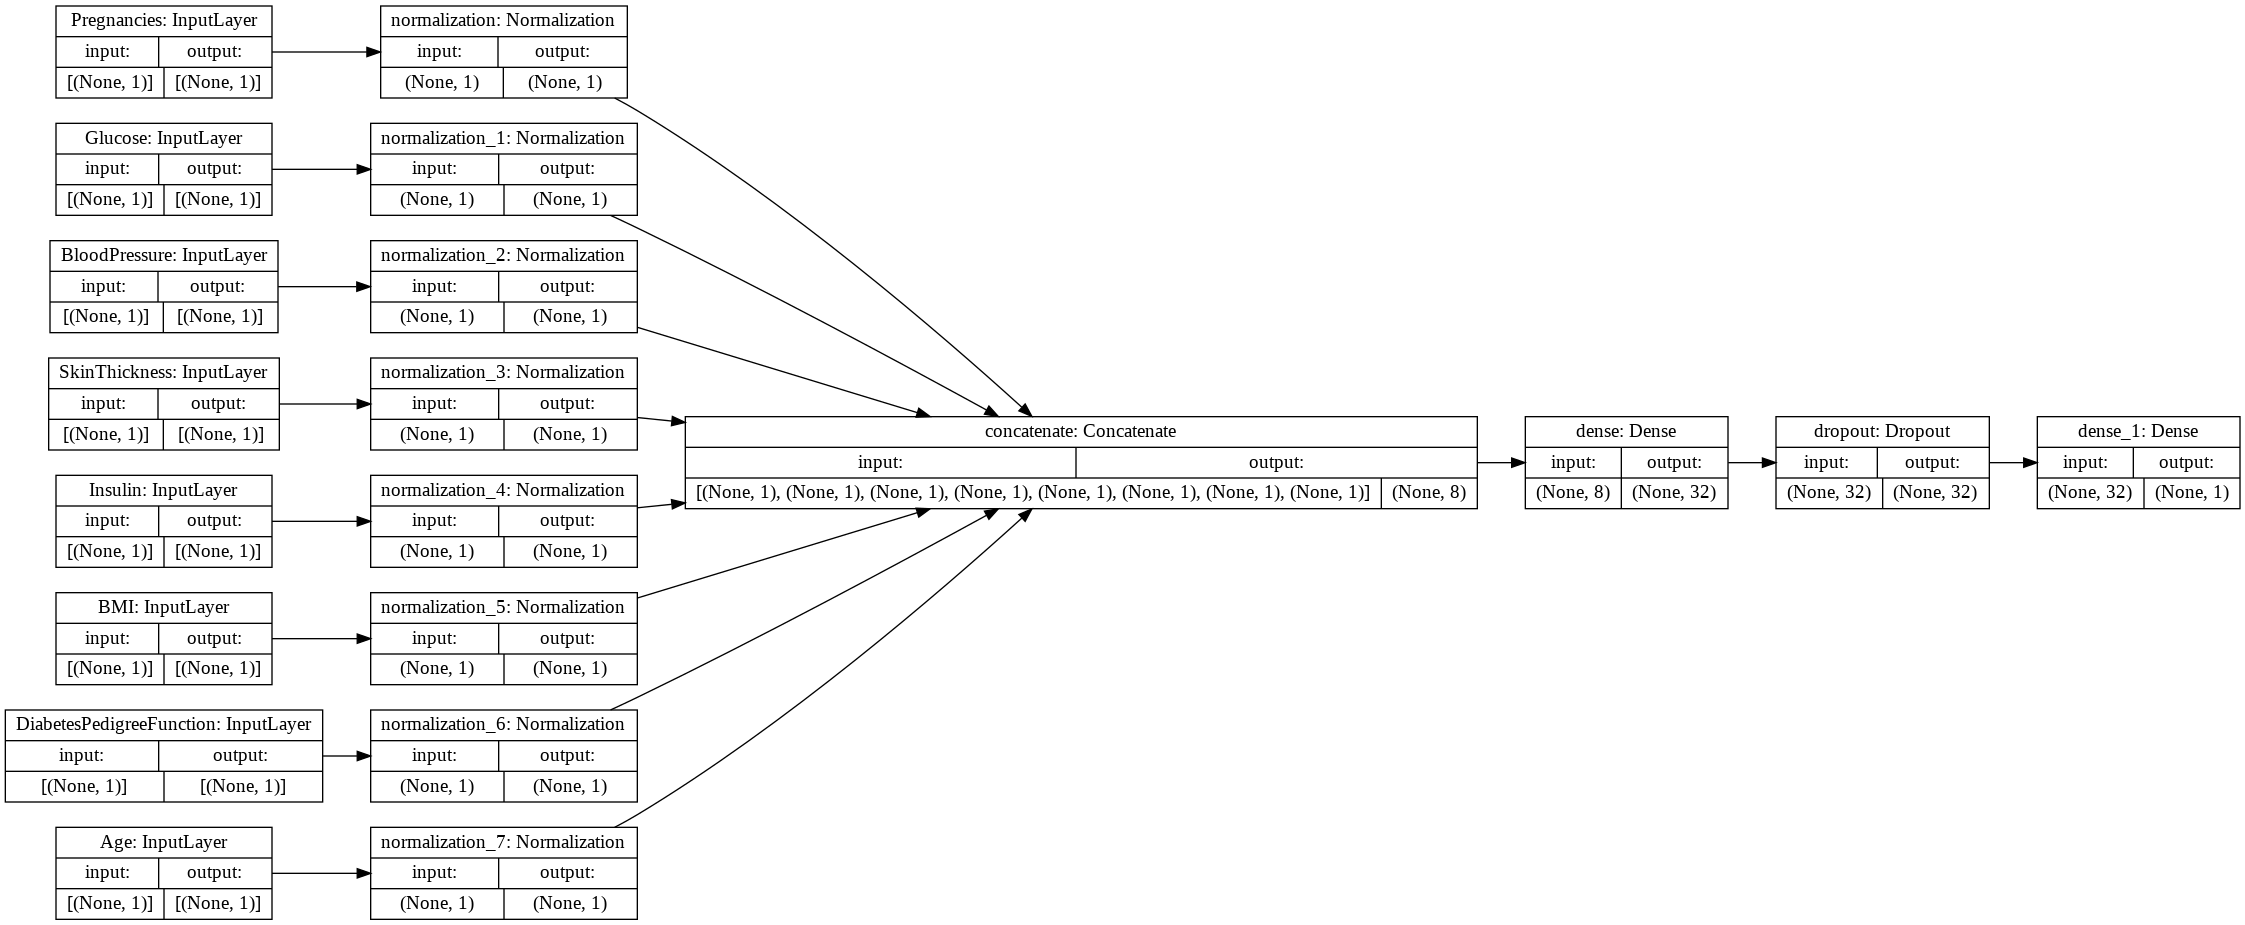

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
h=model.fit(train_ds, epochs=100, validation_data=val_ds)

Epoch 1/100
20/20 [==============================] - 3s 18ms/step - loss: 0.7707 - accuracy: 0.4902 - val_loss: 0.6795 - val_accuracy: 0.5844
Epoch 2/100
20/20 [==============================] - 0s 7ms/step - loss: 0.7018 - accuracy: 0.5700 - val_loss: 0.6363 - val_accuracy: 0.6494
Epoch 3/100
20/20 [==============================] - 0s 7ms/step - loss: 0.6823 - accuracy: 0.6042 - val_loss: 0.6071 - val_accuracy: 0.6883
Epoch 4/100
20/20 [==============================] - 0s 6ms/step - loss: 0.6336 - accuracy: 0.6661 - val_loss: 0.5799 - val_accuracy: 0.7013
Epoch 5/100
20/20 [==============================] - 0s 6ms/step - loss: 0.6238 - accuracy: 0.6564 - val_loss: 0.5614 - val_accuracy: 0.7208
Epoch 6/100
20/20 [==============================] - 0s 8ms/step - loss: 0.6154 - accuracy: 0.6596 - val_loss: 0.5455 - val_accuracy: 0.7338
Epoch 7/100
20/20 [==============================] - 0s 7ms/step - loss: 0.5882 - accuracy: 0.6971 - val_loss: 0.5334 - val_accuracy: 0.7532
Epoch 8/100


In [ ]:
model.evaluate(val_ds)

5/5 [==============================] - 0s 5ms/step - loss: 0.4799 - accuracy: 0.7727


[0.4798815846443176, 0.7727272510528564]

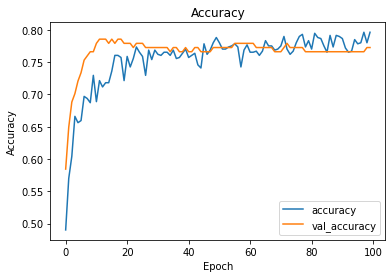

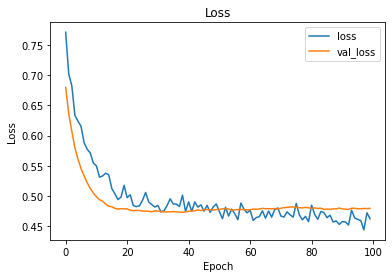

In [ ]:
import matplotlib.pyplot as plt
plt.title("Accuracy")
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel("Accuracy")
plt.legend(['accuracy','val_accuracy'],loc='lower right')
plt.show()


plt.title("Loss")
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.legend(['loss','val_loss'],loc='best')
plt.show()

In [ ]:
sample = {
    "Pregnancies": 2,
    "Glucose": 140,
    "BloodPressure": 82,
    "SkinThickness": 37,
    "Insulin": 0,
    "BMI": 25.6,
    "DiabetesPedigreeFunction": 0.721,
    "Age": 30,
    
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    "This particular patient had a %.1f percent probability "
    "of having diabetes, as evaluated by our model." % (100 * predictions[0][0],)
)

This particular patient had a 49.1 percent probability of having diabetes, as evaluated by our model.


In [ ]:
i=0
predictions = model.predict(val_ds)
predictions.shape=(154,)
for i in range(154):
  if predictions[i]>0.5:
    predictions[i]=1
  else:
    predictions[i]=0

print(predictions)

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1.
 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 1. 0. 1. 0.]


In [ ]:
from sklearn import metrics

print(metrics.accuracy_score(val_dataframe['Outcome'], predictions))

0.6558441558441559


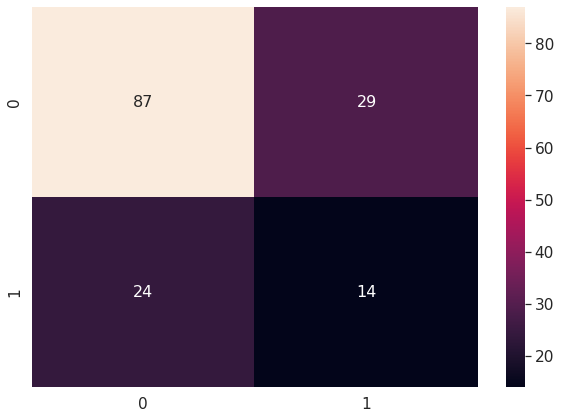

In [ ]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn
confusion_matrix = metrics.confusion_matrix(val_dataframe['Outcome'], predictions)
#confusion_matrix

df_cm = pd.DataFrame(confusion_matrix, range(2), range(2))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

In [ ]:
tflite_model_name = 'sine_model'  
c_model_name = 'sine_model'
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpedai5uu4/assets


INFO:tensorflow:Assets written to: /tmp/tmpedai5uu4/assets


7680

In [ ]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

In [ ]:
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))